In [1]:
import tkinter as tk
from tkinter import ttk
from tkinter import scrolledtext
from tkinter import messagebox
from ttkthemes import ThemedStyle
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import talib as ta
import torch
import torch.nn as nn
import time
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import joblib
import datetime
import warnings
import ttkthemes
import subprocess
import os

warnings.filterwarnings('ignore')
torch.manual_seed(0)
plt.ioff()

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers, 
                            bias=True, 
                            batch_first=True, 
                            dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class StockPredictionViewer:
    def __init__(self, root, index):
        self.root = root
        self.index = index
        self.stock_data_list = []
        self.current_idx = 0
        self.first_create = 0
        self.stock_charts = [plt.figure() for _ in range(len(self.stock_data_list))]
        self.plot_window = None
        self.viewer_button = None
        self.viewer2_button = None
        self.viewer3_button = None
        self.stock_buttons = {} 
        self.unique_stock_symbols = [] 

    def show_menu(self, unique_stock_symbols):
        # 創建下拉式選單
        menu = tk.Menu(self.plot_window, tearoff=0)
        for stock_symbol in unique_stock_symbols:
            menu.add_command(label=f"切換至{stock_symbol}" if language == "chinese" else f"Switch to {stock_symbol}", command=lambda s=stock_symbol: self.switch_stock_chart(s))
        menu.post(self.viewer_button.winfo_rootx(), self.viewer_button.winfo_rooty() + self.viewer_button.winfo_height())

    def create_chart(self):
        self.plot_window = tk.Toplevel(self.root)
        
        if self.index == 1:
            self.plot_window.title("Stock Module Charts" if language == "english" else "股票各模組圖表")
            self.unique_stock_symbols = set(stock_data['stock_symbol'] for stock_data in self.stock_data_list)

            self.viewer_button = ttk.Button(self.plot_window, text="切換選單" if language == "chinese" else "Show Menu", command=lambda: self.show_menu(self.unique_stock_symbols))
            self.viewer_button.pack(side=tk.BOTTOM, padx=10, pady=10)
            
        elif self.index == 2:
            self.plot_window.title("Stock Overlay Charts" if language == "english" else "股票疊加圖表")
        elif self.index == 3:
            self.plot_window.title("Stock Summary Charts" if language == "english" else "股票總結圖表")

        self.figure, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.plot_window)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        
        button_frame = tk.Frame(self.plot_window)
        button_frame.pack(side=tk.BOTTOM)

        self.prev_button = ttk.Button(button_frame, text="Previous Page" if language == "english" else "上一頁", command=self.show_previous)
        self.prev_button.pack(side=tk.LEFT, padx=10, pady=10)

        self.next_button = ttk.Button(button_frame, text="Next Page" if language == "english" else "下一頁", command=self.show_next)
        self.next_button.pack(side=tk.RIGHT, padx=10, pady=10)


    
    def switch_stock_chart(self, stock_symbol):
        # 切換到指定股票的圖片
        for i, stock_data in enumerate(self.stock_data_list):
            if stock_data['stock_symbol'] == stock_symbol:
                self.current_idx = i
                self.show_chart(2)
                break
    
    
    def show_chart(self,create):

        if create == 1:
            self.create_chart()

        if self.index == 1:
            self.ax.clear()
            stock_data = self.stock_data_list[self.current_idx]
            stock_data['df'].loc[stock_data['test_idx']][['Close', 'predicted']].plot(ax=self.ax)


            start_year = stock_data['start_year']
            end_year = stock_data['end_year']
            stock_symbol = stock_data['stock_symbol']
            
            start_year_str = str(start_year)
            end_year_str = str(end_year)
            
            if start_year_str.endswith('.0'):
                start_month = 'Jan.'
            elif start_year_str.endswith('.5'):
                start_month = 'Jul.'
            
            if end_year_str.endswith('.0'):
                end_month = 'Jan.'
            elif end_year_str.endswith('.5'):
                end_month = 'Jul.'

            self.ax.set_title(f"{start_year_str.split('.')[0]} {start_month} ~ {end_year_str.split('.')[0]} {end_month} {stock_symbol}")
            self.canvas.draw()
        elif self.index == 2:
            self.ax.clear()
            self.ax.set_title("Stock Summary")

            stock_data = self.stock_data_list[self.current_idx]
            all_data_combined = stock_data.get('all_data_combined')

            if all_data_combined is not None:
                for stock_symbol in all_data_combined.index.get_level_values(0).unique():
                    stock_data_for_symbol = all_data_combined.loc[stock_symbol]
                    self.ax.plot(stock_data_for_symbol.index, stock_data_for_symbol['Close'], label=f"{stock_symbol} Close")
                    self.ax.plot(stock_data_for_symbol.index, stock_data_for_symbol['predicted'], label=f"{stock_symbol} Predicted")

            self.ax.legend()
            self.canvas.draw()
        elif self.index == 3:
            self.ax.clear()
            stock_data = self.stock_data_list[self.current_idx]

            stock_data_df = stock_data['stock_symbol_data_df']
            stock_data_df.index = stock_data_df.index.get_level_values('Date')

            stock_data_df[['Close', 'predicted']].plot(ax=self.ax)

            self.ax.set_title(f"{stock_data['stock_symbol']}")
            self.canvas.draw()
            
        
        
    def show_previous(self):
        if self.current_idx > 0:
            self.current_idx -= 1
            self.show_chart(2)

    def show_next(self):
        if self.current_idx < len(self.stock_data_list) - 1:
            self.current_idx += 1
            self.show_chart(2)


            
prediction_done = False            
def reset_buttons(reset_button, viewer_button, viewer2_button, viewer3_button,MWU_button,label2):
    global prediction_done
    prediction_done = False  
    if viewer_button:
        viewer_button.destroy()
    if viewer2_button:
        viewer2_button.destroy()
    if viewer3_button:
        viewer3_button.destroy()
    if reset_button:
        reset_button.destroy()
    if total_funds_entry:
        total_funds_entry.destroy()
    if label2:
        label2.destroy()
    if MWU_button:
        MWU_button.destroy()


def print_finish_stocks(folder_path):
    stock_symbols = set()
    easy_stock_symbols = set()
    for filename in os.listdir(folder_path):
        if filename.endswith(".gz"):
            parts = filename.split("_")
            if len(parts) == 2:
                stock_symbol = parts[1].split(".")[0]
                stock_symbols.add(stock_symbol)
            elif len(parts) == 3:
                stock_symbol = parts[2].split(".")[0]
                easy_stock_symbols.add(stock_symbol)
    
    window = tk.Toplevel(root)
    window.title("Stock List" if language == "english" else "股票列表")
    window.geometry("400x500")
    
    label_stock_symbols_title = ttk.Label(window, text="Normal Stock Models:")
    label_stock_symbols_title.pack()
    
    ttk.Label(window, text="").pack()
    
    for stock_symbol in stock_symbols:
        label_stock_symbol = ttk.Label(window, text=stock_symbol)
        label_stock_symbol.pack()

    ttk.Label(window, text="").pack()
    ttk.Label(window, text="").pack()
    
    label_easy_stock_symbols_title = ttk.Label(window, text="Easy Stock Models:")
    label_easy_stock_symbols_title.pack()
    
    ttk.Label(window, text="").pack()
    
    for easy_stock_symbol in easy_stock_symbols:
        label_easy_stock_symbol = ttk.Label(window, text=easy_stock_symbol)
        label_easy_stock_symbol.pack()


def change_app():
    try:
        subprocess.Popen(["./training_program.exe"])
    except FileNotFoundError:
        warning_title = "警告" if language == "chinese" else "Warning"
        warning_text = "發生錯誤，無法開啟訓練APP" if language == "chinese" else "An error occurred and the training APP could not be opened"
        messagebox.showwarning(warning_title, warning_text)

MWU_dates = np.array([])

def predict_stocks():
    global prediction_done
    global all_data
    global stocks
    global MWU_dates
    global language
    global label2, MWU_button, viewer_button, viewer2_button, viewer3_button, reset_button, prediction_completed_message
    if prediction_done:
        if language == "chinese":
            messagebox.showwarning("警告", "已經進行過預測，請先重置！")
        else:
            messagebox.showwarning("Warning", "Prediction has already been performed. Please reset first!")
        return

    stock_symbols = stock_entry.get().upper()
    stocks = stock_symbols.split(", ")

    param_grid = {
        'hidden_dim': [64, 128],
        'num_layers': [1, 2],
        'num_epochs': [100, 150]
    }

    all_data = {}
    first_close_list = []
    
    stock_data_list = []
    stock_data_list2 = []
    stock_data_list3 = []

    count_stocks = 0
    for stock_symbol in stocks:
        count_stocks +=1
        stock_symbol_data = {}

        data = yf.Ticker(stock_symbol.strip()).history(period='max')
        start_df = pd.DataFrame(data)
        
        try:
            start_df.drop('Dividends', axis=1, inplace=True)
        except Exception as e:
            if language == "chinese":
                messagebox.showwarning("警告", f"查無 {stock_symbol} 這支股票")
            else:
                messagebox.showwarning("Warning", f"No data found for the stock symbol: {stock_symbol}")
            return
            
        start_df.drop('Stock Splits', axis=1, inplace=True)

        start_df['name'] = stock_symbol
        
        start_df['MACD'] = ta.MACD(start_df['Close'])[0]
        start_df['ADX'] = ta.ADX(start_df['High'],start_df['Low'],start_df['Close'])
        start_df['CCI'] = ta.CCI(start_df['High'],start_df['Low'],start_df['Close'])
        start_df['K'], start_df['D'] = ta.STOCH(start_df['High'],start_df['Low'],start_df['Close'])
        start_df['MFI'] = ta.MFI(start_df['High'],start_df['Low'],start_df['Close'],start_df['Volume'])
        start_df['WILLR'] = ta.WILLR(start_df['High'],start_df['Low'],start_df['Close'])
        start_df.dropna(inplace=True)

        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 
                    'ADX', 'CCI', 'K', 'D', 'MFI', 'WILLR']

        
        currentDateTime = datetime.datetime.now()
        date = currentDateTime.date()
        year = date.strftime("%Y")
        year = int(year)
        month = date.strftime("%m")
        month = int(month)
        
        start_year = 2008.5
        end_year = 2014
        now_date = year
        
        if month < 7:
            num_segments = 2*(year-end_year+1)-1
            now_date += 0.5
        else:
            num_segments = 2*(year-end_year+1)
            now_date += 1
            
        for segment in range(num_segments):
            start_year += 0.5
            end_year += 0.5

            if end_year == now_date:
                try:
                    model = joblib.load(filename=f"Model/{start_year}~{end_year}_{stock_symbol}.gz")
                except FileNotFoundError:
                    try:
                        model = joblib.load(filename=f"Model/easy_{start_year}~{end_year}_{stock_symbol}.gz")
                    except FileNotFoundError:
                        if language == "chinese":
                            messagebox.showwarning("警告", f"{stock_symbol}需要進行模組更新")
                        else:
                            messagebox.showwarning("Warning", f"The model for {stock_symbol} needs to be updated.")
                        return
            else:
                try:
                    model = joblib.load(filename=f"Model/{start_year}~{end_year}_{stock_symbol}.gz")
                except FileNotFoundError:
                    try:
                        model = joblib.load(filename=f"Model/easy_{start_year}~{end_year}_{stock_symbol}.gz")
                    except FileNotFoundError:
                        if language == "chinese":
                            messagebox.showwarning("警告", f"{stock_symbol}尚未進行訓練或模組遺失(建議重新訓練)")
                        else:
                            messagebox.showwarning("Warning", f"{stock_symbol} has not been trained or the model is missing (it is recommended to retrain).")                       
                        return

            
            df = start_df[ (start_df.index.year >= np.floor(start_year)) & (start_df.index.year <= end_year) &
                           (start_df.index.year + start_df.index.month / 12 >= start_year) &
                           (start_df.index.year + start_df.index.month / 12 <= end_year)]
            #print(start_year,' ~ ',end_year)

            train_data = df[(df.index.year >= np.floor(start_year)) &
                            (df.index.year + df.index.month / 12 <= end_year - 0.5)]
            if segment == 0:
                first_close_list.append(train_data['Close'].iloc[-1])

        
            test_data = df[(df.index.year + df.index.month / 12 > end_year - 0.5) &
                           (df.index.year + df.index.month / 12 <= end_year)]

            x_train = train_data[features].values
            y_train = train_data['Close'].values.reshape(-1, 1)

            x_test = pd.concat([train_data[-10:][features], test_data[features]], axis=0)
            x_test = x_test.values

            y_test = pd.concat([train_data[-10:]['Close'], test_data['Close']], axis=0)
            y_test = y_test.values.reshape(-1, 1)  


            scaler = StandardScaler()
            scaler_y = StandardScaler()
            scaler.fit(x_train)
            scaler_y.fit(y_train)
            x_train = scaler.transform(x_train)
            y_train = scaler_y.transform(y_train)
            x_test = scaler.transform(x_test)
            y_test = scaler_y.transform(y_test) 


            x_train_batch = []
            x_test_batch = []
            roll_steps = 11

            for index in range(roll_steps-1, len(x_train)):
                x_train_batch.append(x_train[index-roll_steps+1:index])
            x_train_batch = np.array(x_train_batch)

            y_train = y_train[roll_steps-1:]

            for index in range(roll_steps-1, len(x_test)):
                x_test_batch.append(x_test[index-roll_steps+1:index])
            x_test_batch = np.array(x_test_batch)

            y_test = y_test[roll_steps-1:]


            x_train_batch = torch.from_numpy(x_train_batch).type(torch.Tensor)
            x_test_batch = torch.from_numpy(x_test_batch).type(torch.Tensor)
            y_train = torch.from_numpy(y_train).type(torch.Tensor)
            y_test = torch.from_numpy(y_test).type(torch.Tensor)

            
            y_train_pred = model(x_train_batch)
            y_test_pred = model(x_test_batch)
            rmse = np.sqrt(mean_squared_error(y_test.detach().numpy(), y_test_pred.detach().numpy()))
            #print("RMSE:", rmse)

            df['predicted'] = np.nan

            train_idx = df.iloc[roll_steps-2:x_train.shape[0]-1].index
            test_idx = df.iloc[x_train.shape[0]-1:-1].index
            if count_stocks == 1:
                MWU_dates = np.append(MWU_dates, test_idx)

            df.loc[train_idx, 'predicted'] = scaler_y.inverse_transform(y_train_pred.detach().numpy())
            df.loc[test_idx, 'predicted'] = scaler_y.inverse_transform(y_test_pred.detach().numpy())

            df['signal'] = 0

            #df.loc[df['predicted'] > 1.01*df['Close'], 'signal'] = -1
            #df.loc[df['predicted'] < 0.99*df['Close'], 'signal'] = 1
            df.loc[df['predicted'] > 1.01*df['predicted'].shift(1), 'signal'] = -1
            df.loc[df['predicted'] < 0.99*df['predicted'].shift(1), 'signal'] = 1

            df['position'] = df['signal'].shift(1)
            df.loc[df['position'] == 0, 'position'] = np.nan
            df['position'].fillna(method='ffill', inplace=True)
            df['position'].fillna(0, inplace=True)


            df['price_diff'] = df['Close'] - df['Close'].shift(1) #df['close'].shift(1) 是前一天的
            df['price_diff'].fillna(0, inplace=True)


            df['transaction cost'] = 0 #計算交易成本
            df.loc[df['position']!=df['position'].shift(1), 'transaction cost'] = -df['Close'].shift(1)*0.0005  
            df['transaction cost'].fillna(0, inplace=True)
            
            
            df['pnl'] = df['price_diff']
            df['predict_pnl'] = df['predicted'] - df['predicted'] .shift(1)
            df['return'] = df['pnl']/df['Close'].shift(1) 
            df['return'].fillna(0, inplace=True)


            df['pnl_in'] = (df['price_diff'])*-1
            df['pnl_out'] = ((-1*df['price_diff']))*-1
            df['predicted'] = df['predicted'].shift(1)
            

            stock_data_list.append({
                'start_year': start_year,
                'end_year': end_year,
                'stock_symbol': stock_symbol,
                'df': df,
                'test_idx': test_idx,
            })      
            
        
                
            if stock_symbol in all_data:
                all_data[stock_symbol] = pd.concat([all_data[stock_symbol], df.loc[test_idx[1]:]])
                stock_symbol_data[stock_symbol] = pd.concat([stock_symbol_data[stock_symbol], df.loc[test_idx[1]:]])
            else:
                all_data[stock_symbol] = df.loc[test_idx[1]:]
                stock_symbol_data[stock_symbol] = df.loc[test_idx[1]:]
        
        
        stock_symbol_data_df = pd.concat(stock_symbol_data.values(), keys=stock_symbol_data.keys())
        stock_data_list3.append({
            'stock_symbol_data_df': stock_symbol_data_df,
            'stock_symbol': stock_symbol
        })
         
        
        
     # 創建 StockPredictionViewer 實例，只在迴圈外創建一次
    viewer = StockPredictionViewer(root,1)
    viewer.stock_data_list = stock_data_list

    global all_data_combined
    all_data_combined = pd.concat(all_data.values(), keys=all_data.keys())
    stock_data_list2.append({
        'all_data_combined': all_data_combined,
        'stock_symbol': stock_symbol
    })
    #print(stock_data_list2)
    viewer2 = StockPredictionViewer(root,2)
    viewer2.stock_data_list = stock_data_list2  
    
    viewer3 = StockPredictionViewer(root,3)
    viewer3.stock_data_list = stock_data_list3  
    
    
    #print(all_data_combined)
    
    
    label2_text = "請輸入MWU分配的資金" if language == "chinese" else "Please Enter Funds for MWU Allocation"
    label2 = ttk.Label(root, text=label2_text, foreground="black", font=('Helvetica', 12))
    label2.pack(padx=10, pady=10)

    global total_funds_entry
    total_funds_entry = ttk.Entry(root, width=30)
    total_funds_entry.pack(padx=10, pady=10)

    MWU_button_text = "開始MWU策略" if language == "chinese" else "Start MWU Strategy"
    MWU_button = ttk.Button(root, text=MWU_button_text, style='Custom.TButton', command=weight_select)
    MWU_button.pack(padx=10, pady=10)
    
    global first_close
    first_close = np.array(first_close_list)

    viewer_button_text = "顯示各模組圖表" if language == "chinese" else "Show Models Chart"
    viewer_button = ttk.Button(root, text=viewer_button_text, style='Custom.TButton', command=lambda: viewer.show_chart(1))
    viewer_button.pack(side=tk.LEFT, padx=35, pady=10)


    viewer3_button_text = "顯示總結圖表" if language == "chinese" else "Show Summary Chart"
    viewer3_button = ttk.Button(root, text=viewer3_button_text, style='Custom.TButton', command=lambda: viewer3.show_chart(1))
    viewer3_button.pack(side=tk.LEFT, padx=9, pady=10)


    viewer2_button_text = "顯示疊加圖表" if language == "chinese" else "Show Overlay Chart"
    viewer2_button = ttk.Button(root, text=viewer2_button_text, style='Custom.TButton', command=lambda: viewer2.show_chart(1))
    viewer2_button.pack(side=tk.LEFT, padx=40, pady=10)
    
    reset_button_text = "重置" if language == "chinese" else "Reset"
    reset_button = ttk.Button(root, text=reset_button_text, style='Custom.TButton', command=lambda: reset_buttons(reset_button, viewer_button, viewer2_button, viewer3_button, MWU_button, label2))
    reset_button.pack(side=tk.LEFT, padx=10, pady=10)
    
    
    
    prediction_done = True
    prediction_completed_message = "股票預測完成!" if language == "chinese" else "Stock prediction completed!"
    messagebox.showinfo("Prediction Result", prediction_completed_message)

In [2]:
def compute_Sharpe(rets):
    return np.sqrt(250) * rets.mean() / rets.std()




def plot_graph(day, total_funds, weights, diff_weights):
    time_axis = [date.to_pydatetime() for date in MWU_dates[:day]]
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(time_axis, total_funds[:day], label='total_funds')
    
    # 計算最大回撤
    max_drawdown = 0
    start_idx = 0
    end_idx = 0
    peak = total_funds[0]
    for i in range(1, day):
        if total_funds[i] > peak:
            peak = total_funds[i]
        else:
            drawdown = (peak - total_funds[i]) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                start_idx = np.argmax(total_funds[:i+1])
                end_idx = i
                
    start_date = time_axis[start_idx]
    end_date = time_axis[end_idx]

    ax.plot(start_date, total_funds[start_idx], marker='o', markersize=8, color='red', label='Max Drawdown Start')
    ax.plot(end_date, total_funds[end_idx], marker='o', markersize=8, color='green', label='Max Drawdown End')
    
    returns = np.diff(total_funds[:day]) / total_funds[:day][:-1]
    sharp_ratio = compute_Sharpe(returns)
    
    ax.annotate(f'Max Drawdown: {max_drawdown:.2%}\nSharpe Ratio: {sharp_ratio:.2f}\n', xy=(1, 0), xycoords='axes fraction', xytext=(-10, 10), textcoords='offset points', ha='right', va='bottom', fontsize=12)

    minus = 0
    for i, (stock_name, weight, diff_weights) in enumerate(zip(stocks, weights[day-1],diff_weights[day-1])):
        if diff_weights > 0.001:
            rate_arrow = '↑'
            color = 'red'
        elif diff_weights < -0.001:
            rate_arrow = '↓'  
            color = 'green'
        else:
            rate_arrow = '-'
            color = 'gray'
        
        total_diff = diff_weights * total_funds[day-2]
        stock_index = 0
        if total_diff > 0:
            annotation_text = f'+{total_diff:.2f}'
        else:
            annotation_text = f'{total_diff:.2f}'
            
        ax.annotate(f'{stock_name}: {weight*100:.0F}% {rate_arrow}', xy=(1.125, 0.98 - minus * 0.05), xycoords='axes fraction', fontsize=11, ha='right', color=color)
        minus+=1
        ax.annotate(annotation_text, xy=(1.125, 0.98 - minus * 0.05), xycoords='axes fraction', fontsize=11, ha='right', color=color)
        minus+=1
    
    print_day = time_axis[day-1] + timedelta(days=1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Portfolio Value: {total_funds[day-1]:.2f} ({print_day.strftime("%Y-%m-%d")})')
    ax.legend()
        
    return fig


def weight_select():
    global cmp_weights
    global n_days
    global n_stocks
    n_days = len(all_data[stocks[0]])
    n_stocks = len(stocks) 
    cmp_weights = np.zeros((n_days+1, n_stocks))
    
    weight_window = tk.Toplevel(root)
    weight_window.title("對照組初始權重選擇" if language == "chinese" else "MWU Control Group Initial Weight Selection")
    
    cmp_weight_label_text = "請輸入MWU對照組分配權重（總和應為100%）：" if language == "chinese" else "Please Enter Initial Weights for MWU Control Group (Total should be 100%):"
    cmp_weight_label = tk.Label(weight_window, text=cmp_weight_label_text)
    cmp_weight_label.pack()
    
    weight_frame = tk.Frame(weight_window)
    weight_frame.pack()
    
    initial_weight_labels = []
    initial_weight_entries = []
    default_weight = "{:.2f}".format(100 / n_stocks)
    for i, stock in enumerate(stocks):
        label_text = f"{stock}：" if language == "chinese" else f"{stock}:"
        label = tk.Label(weight_frame, text=label_text)
        label.grid(row=i, column=0, padx=10, pady=5, sticky="e")
        entry = tk.Entry(weight_frame)
        entry.insert(0, default_weight)
        entry.grid(row=i, column=1, padx=10, pady=5)
        initial_weight_labels.append(label)
        initial_weight_entries.append(entry)

    remaining_percentage_label_text = "剩餘百分比: 0%" if language == "chinese" else "Remaining Percentage: 0%"
    remaining_percentage_label = tk.Label(weight_window, text=remaining_percentage_label_text, font=("Arial", 10, "italic"))
    remaining_percentage_label.pack()
    
    
    def calculate_remaining_percentage(dummy=None):
        total_weight = sum(float(entry.get()) for entry in initial_weight_entries if entry.get())
        remaining_percentage = 100 - total_weight
        #print("remaining_percentage=",remaining_percentage)
        remaining_text =  "剩餘百分比" if language == "chinese" else "Remaining Percentage"
        remaining_percentage_label.config(text=f"{remaining_text}：{remaining_percentage:.2f}%")



    def confirm_weights():
        total_weight = 0  #
        
        for i, entry in enumerate(initial_weight_entries):
            try:
                weight = float("{:.2f}".format(float(entry.get()))) 
                cmp_weights[0][i] = weight/100
                total_weight += weight
            except ValueError:
                messagebox.showwarning("警告" if language == "chinese" else "Warning",
                                       "請輸入有效的數字。" if language == "chinese" else "Please enter valid numbers.")
                return
                
        if total_weight < 99.9 or total_weight > 100.1:
            messagebox.showwarning("警告" if language == "chinese" else "Warning",
                                   "權重總和必須為 100。" if language == "chinese" else "Total weight must be 100.")
            return
        
        weight_window.destroy() 
        MWU_algorithtm()

    
    for entry in initial_weight_entries:
        entry.bind("<FocusOut>", calculate_remaining_percentage)
        entry.bind("<KeyRelease>", calculate_remaining_percentage)

    

    confirm_button_text = "確認" if language == "chinese" else "Confirm"
    confirm_button = tk.Button(weight_window, text=confirm_button_text, command=confirm_weights)
    confirm_button.pack(pady=10)



def MWU_algorithtm():
    global all_data
    global stocks
    global total_funds
    global cmp_total_funds
    global cmp_weights
    global n_days
    global n_stocks
    
    stock_signal = np.zeros((n_days+1, n_stocks))  
    stocks_close  = np.zeros((n_days+1, n_stocks))
    next_stocks_close  = np.zeros((n_days+1, n_stocks))
    ones_pnl = np.zeros((n_days+1, n_stocks))
    predict_ones_pnl = np.zeros((n_days+1, n_stocks))
    
    total_funds = np.zeros(n_days)  
    cmp_total_funds = np.zeros(n_days)
    
    rest_funds = np.zeros(n_days+1) 
    
    weights = np.zeros((n_days+1, n_stocks))  

    diff_weights = np.zeros((n_days+1, n_stocks))
    diff_cmp_weights = np.zeros((n_days+1, n_stocks))
    
    stocks_funds = np.zeros((n_days+1, n_stocks))  
    cmp_stocks_funds = np.zeros((n_days+1, n_stocks))
    
    num_of_stocks = np.zeros((n_days+1, n_stocks)) 
    cmp_num_of_stocks = np.zeros((n_days+1, n_stocks))
    
    stock_pnl = np.zeros((n_days+1, n_stocks)) 
    cmp_stock_pnl = np.zeros((n_days+1, n_stocks))
    
    
    final_pnl_sum = np.zeros(n_days+1)  
    cmp_final_pnl_sum = np.zeros(n_days+1) 

    stock_position = np.zeros((n_days+1, n_stocks)) 
    cmp_stock_position = np.zeros((n_days+1, n_stocks))

    global total_funds_entry
    total_funds[0] = float(total_funds_entry.get())
    cmp_total_funds[0] = float(total_funds_entry.get())
    #print(' ')


    weights[0] = np.full(n_stocks, 1/n_stocks)
    
    beta = np.sqrt(np.log(n_stocks) / (n_days))
    correction = 1
    
    stocks_funds[0] = total_funds[0] / n_stocks
    cmp_stocks_funds[0] = cmp_total_funds[0] / n_stocks
    

    global first_close
    num_of_stocks[0] = stocks_funds[0] / first_close
    cmp_num_of_stocks[0] = cmp_stocks_funds[0] / first_close
    
    
    
    for day in range(n_days-1):
        #print('day: ',day+1)
        ones_pnl[day+1] = [all_data[stock]['pnl'][day] for stock in stocks]
        stocks_close[day+1] = [all_data[stock]['Close'][day-1] for stock in stocks]
        if day==0:
            stocks_close[day+1] = [all_data[stock]['Close'][day] for stock in stocks]
        next_stocks_close[day+1] = [all_data[stock]['Close'][day] for stock in stocks]
        predict_ones_pnl[day+1] = [all_data[stock]['predict_pnl'][day] for stock in stocks]
        stock_signal[day+1] = [all_data[stock]['position'][day] for stock in stocks]
        
        for i in range(n_stocks):
            if ones_pnl[day+1][i] < 0 and predict_ones_pnl[day+1][i] < 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i] * 3.25
            elif ones_pnl[day+1][i] > 0 and predict_ones_pnl[day+1][i] > 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i] *3

        '''for i in range(n_stocks):
            if ones_pnl[day+1][i] < 0 and predict_ones_pnl[day+1][i] < 0:
                stock_pnl[day+1][i] = predict_ones_pnl[day+1][i] * 3.25
            elif ones_pnl[day+1][i] > 0 and predict_ones_pnl[day+1][i] > 0:
                stock_pnl[day+1][i] = predict_ones_pnl[day+1][i] *3'''

        '''for i in range(n_stocks):
            if ones_pnl[day+1][i] < 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i] * 10
            elif ones_pnl[day+1][i] > 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i] * 10'''
                

        '''for i in range(n_stocks):
            if predict_ones_pnl[day+1][i] < 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i] * 1.15
            elif predict_ones_pnl[day+1][i] > 0:
                stock_pnl[day+1][i] = ones_pnl[day+1][i]'''
        
        weights[day+1] = weights[day] * np.exp(-beta * -(stock_pnl[day+1]) * correction)

        for i in range(n_stocks):
            if weights[day+1][i] < 0.01:
                weights[day+1][i] = 0.01
        weights[day+1] /= np.sum(weights[day+1]) 

        
        diff_weights[day+1] = weights[day+1]-weights[day]

        for i in range(n_stocks):
            cmp_weights[day+1][i] = cmp_weights[0][i]

        diff_cmp_weights[day+1] = cmp_weights[day+1]-cmp_weights[day]
        
        
        stocks_funds[day+1] = total_funds[day]*weights[day+1]
        cmp_stocks_funds[day+1] = cmp_total_funds[day]*cmp_weights[day+1]

        for i in range(n_stocks):
            num_of_stocks[day+1][i] =  stocks_funds[day+1][i] / stocks_close[day+1][i]
            cmp_num_of_stocks[day+1][i] =  cmp_stocks_funds[day+1][i] / stocks_close[day+1][i]


        for i in range(n_stocks):
            total_funds[day+1] +=  num_of_stocks[day+1][i] * next_stocks_close[day+1][i]
            cmp_total_funds[day+1] +=  cmp_num_of_stocks[day+1][i] * next_stocks_close[day+1][i] 
        

        #-1 (全賣)
        #1  (權重)
        #我們當天每支股票要買還是賣多少張
        '''for i in range(n_stocks):
            if(stock_signal[day+1][i] == -1):
                #根據今天分配給每支股票的資金/每支股票當天的收盤價 算出目前每支股票有多少張
                #全部賣掉
                stock_position[day+1][i] = -num_of_stocks[day][i]
                num_of_stocks[day+1][i] = 0
                rest_funds[day+1] +=  stocks_funds[day][i]

                #今天交易後每支股票的損益 
                stock_pnl[day+1][i] = abs(stock_position[day+1][i]) * ones_pnl[day+1][i]

            elif(stock_signal[day+1][i] == 1):
                #依照權重買入賣出
                stock_position[day+1][i] = num_of_stocks[day+1][i] - num_of_stocks[day][i]

                if(stock_position[day+1][i] >= 0):
                    #est_funds[day+1] -=  stock_position[day+1][i] * stocks_close[day+1][i]
                    #今天交易後每支股票的損益
                    stock_pnl[day+1][i] = abs(stock_position[day+1][i]) * ones_pnl[day+1][i]
                else:
                    #rest_funds[day+1] +=  abs(stock_position[day+1][i]) * stocks_close[day+1][i]
                    #今天交易後每支股票的損益
                    stock_pnl[day+1][i] = -1 * abs(stock_position[day+1][i]) * ones_pnl[day+1][i]'''
        
        for i in range(n_stocks):
            if((num_of_stocks[day+1][i] - num_of_stocks[day][i]) < 0 and stock_signal[day+1][i] == -1):
                
                stock_position[day+1][i] = num_of_stocks[day+1][i] - num_of_stocks[day][i]
                
                #rest_funds[day+1] +=  abs(stock_position[day+1][i])*stocks_close[day+1][i]
                #今天交易後每支股票的損益
                
                #stock_pnl[day+1][i] = abs(stock_position[day+1][i]) * ones_pnl[day+1][i]
               
            elif((num_of_stocks[day+1][i] - num_of_stocks[day][i]) > 0 and stock_signal[day+1][i] == 1):
                #依照權重買入賣出
                stock_position[day+1][i] = num_of_stocks[day+1][i] - num_of_stocks[day][i]
                
                #stock_pnl[day+1][i] = abs(stock_position[day+1][i]) * ones_pnl[day][i]
                
            if((cmp_num_of_stocks[day+1][i] - cmp_num_of_stocks[day][i]) < 0 and stock_signal[day+1][i] == -1):
                cmp_stock_position[day+1][i] = cmp_num_of_stocks[day+1][i] - cmp_num_of_stocks[day][i]
                #cmp_stock_pnl[day+1] = abs(cmp_stock_position[day+1][i]) * ones_pnl[day+1][i]
            
            elif((cmp_num_of_stocks[day+1][i] - cmp_num_of_stocks[day][i]) > 0 and stock_signal[day+1][i] == 1):
                cmp_stock_position[day+1][i] = cmp_num_of_stocks[day+1][i] - cmp_num_of_stocks[day][i]
                #cmp_stock_pnl[day+1][i] = abs(cmp_stock_position[day+1][i]) * ones_pnl[day+1][i]
        
        
        cmp_stock_pnl[day+1] = ones_pnl[day+1]
        
        for i in range(n_stocks):
            final_pnl_sum[day] += total_funds[day+1]-total_funds[day]
            cmp_final_pnl_sum[day] += cmp_total_funds[day+1]-cmp_total_funds[day]

    

    new_window = tk.Toplevel(root)
    new_window.resizable(False, False)
    new_window.title("MWU策略圖表" if language == "chinese" else "MWU Strategy Chart")

    label_frame = tk.Frame(new_window)
    label_frame.pack()

    label_text = '選擇天數' if language == "chinese" else 'Select Days'
    label = tk.Label(label_frame, text=label_text)
    label.pack(side='left')

    day_scale = tk.Scale(new_window, from_=1, to=len(total_funds), orient=tk.HORIZONTAL, length=1200)
    day_scale.pack(side='top', expand=True, fill='x')

    day_scale.pack()
    
    
    def update_graph():
        selected_day = int(move_day_entry.get())
        if selected_day < 1 or selected_day > len(total_funds):
            warning_title = "警告" if language == "chinese" else "Warning"
            warning_text = "輸入的天數不符" if language == "chinese" else "The entered number of days is invalid"
            messagebox.showwarning(warning_title, warning_text)
            return
        fig = plot_graph(selected_day, total_funds , weights, diff_weights)
        day_scale.set(selected_day)
        canvas.figure = fig
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    def compare_MWU(event=None):
        compare_fig = plot_graph(current_day.get(), cmp_total_funds , cmp_weights, diff_cmp_weights)
        canvas.figure = compare_fig
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
    def back_MWU(event=None):
        back_fig = plot_graph(current_day.get(), total_funds , weights, diff_weights)
        canvas.figure = back_fig
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
    selected_day_text = '輸入天數：' if language == "chinese" else 'Enter Days:'
    selected_day_label = tk.Label(new_window, text=selected_day_text)
    selected_day_label.pack()

    move_day_entry = tk.Entry(new_window)
    move_day_entry.pack()

    confirm_button_text = '確認' if language == "chinese" else 'Confirm'
    confirm_button = tk.Button(new_window, text=confirm_button_text, command=update_graph)
    confirm_button.pack()
    
    compare_MWU_button_text = 'MWU對照組' if language == "chinese" else 'MWU Control Group'
    compare_MWU_button = tk.Button(new_window, text=compare_MWU_button_text)
    compare_MWU_button.pack()
    compare_MWU_button.bind('<ButtonPress-1>', compare_MWU)
    compare_MWU_button.bind('<ButtonRelease-1>', back_MWU) 
    
    current_day = tk.IntVar(value=1)
    fig = plot_graph(current_day.get(), total_funds , weights, diff_weights)

    canvas = FigureCanvasTkAgg(fig, master=new_window)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    def on_slider_change(value):
        current_day.set(value)
        new_fig = plot_graph(current_day.get(), total_funds ,weights, diff_weights)
        canvas.figure.clear()
        canvas.figure = new_fig
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    day_scale.config(command=lambda value: on_slider_change(int(value)))

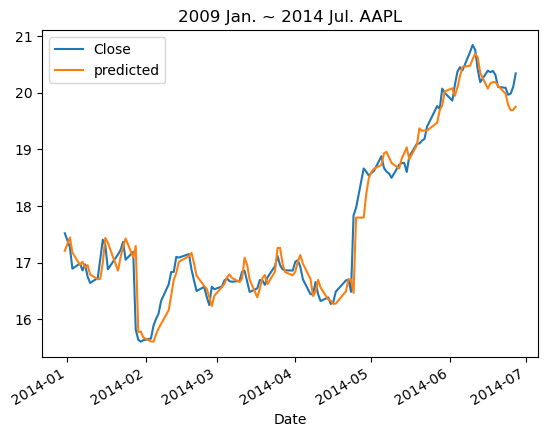

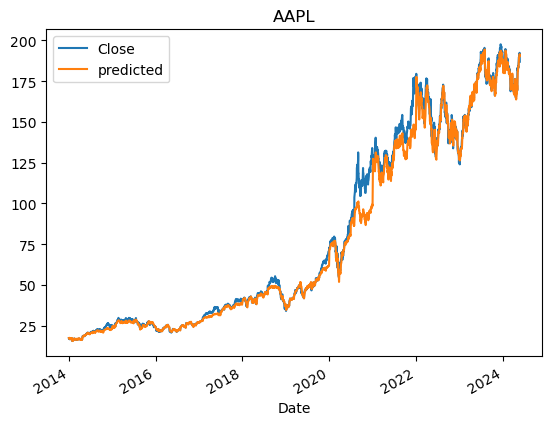

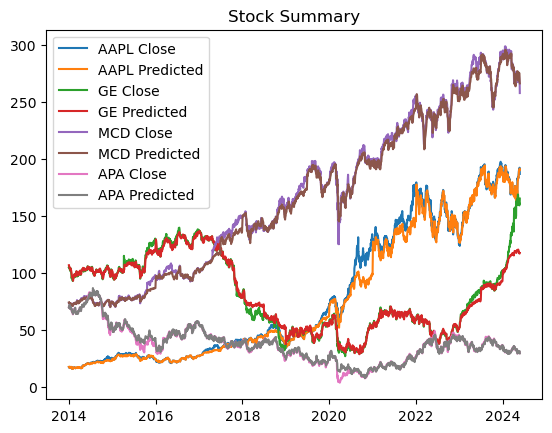

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

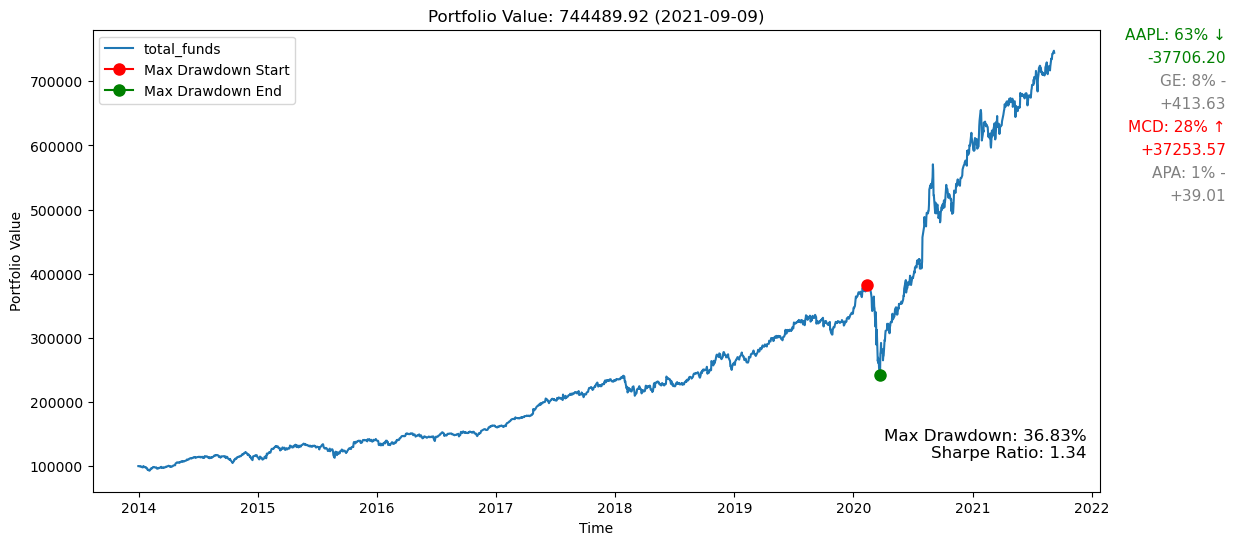

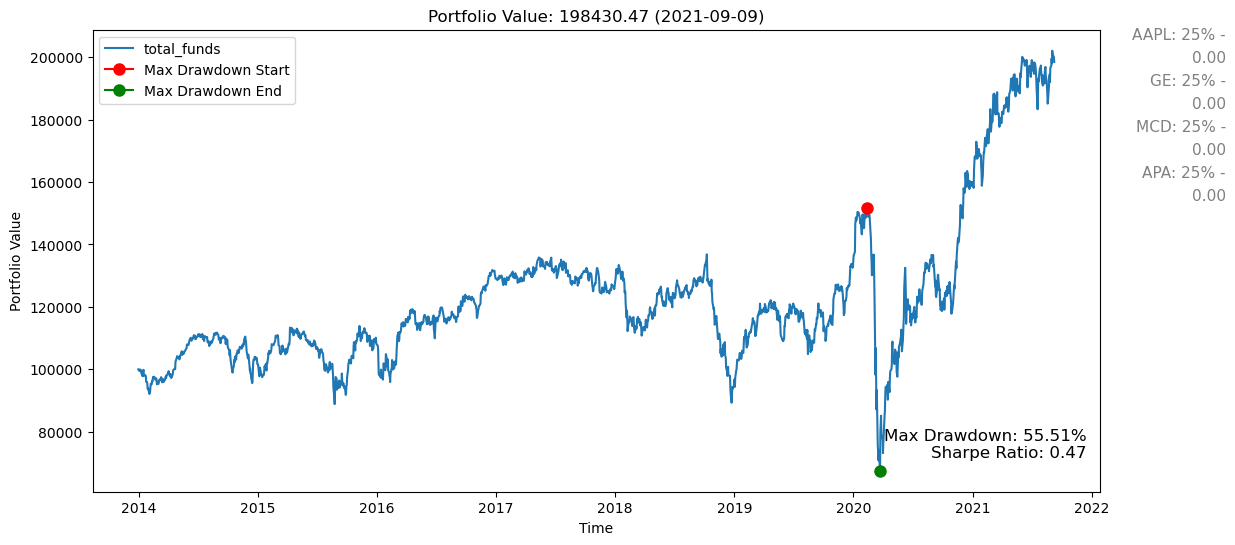

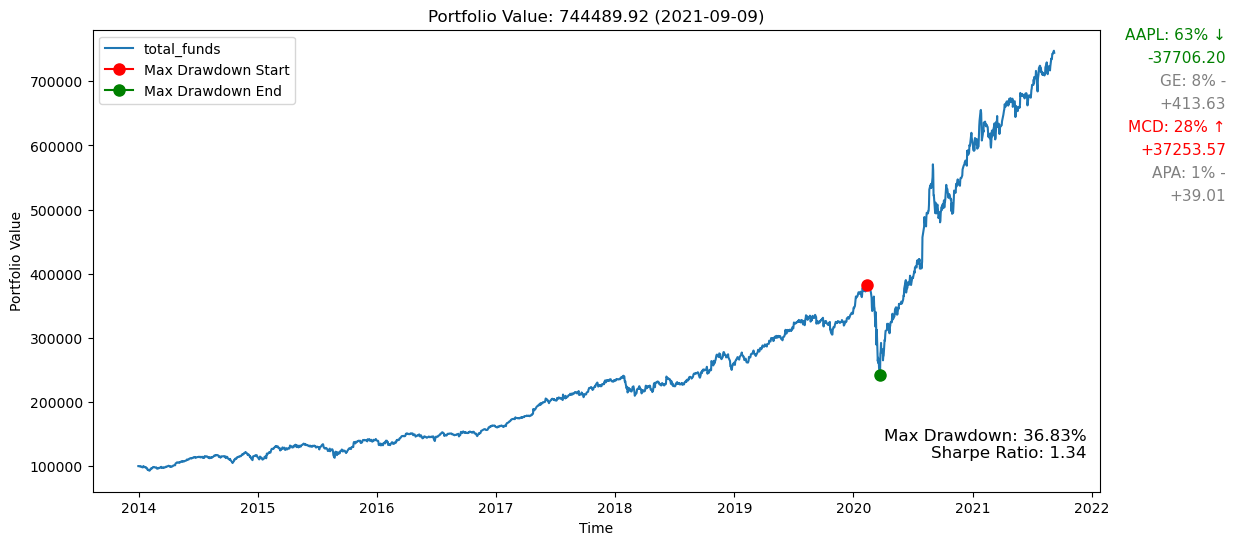

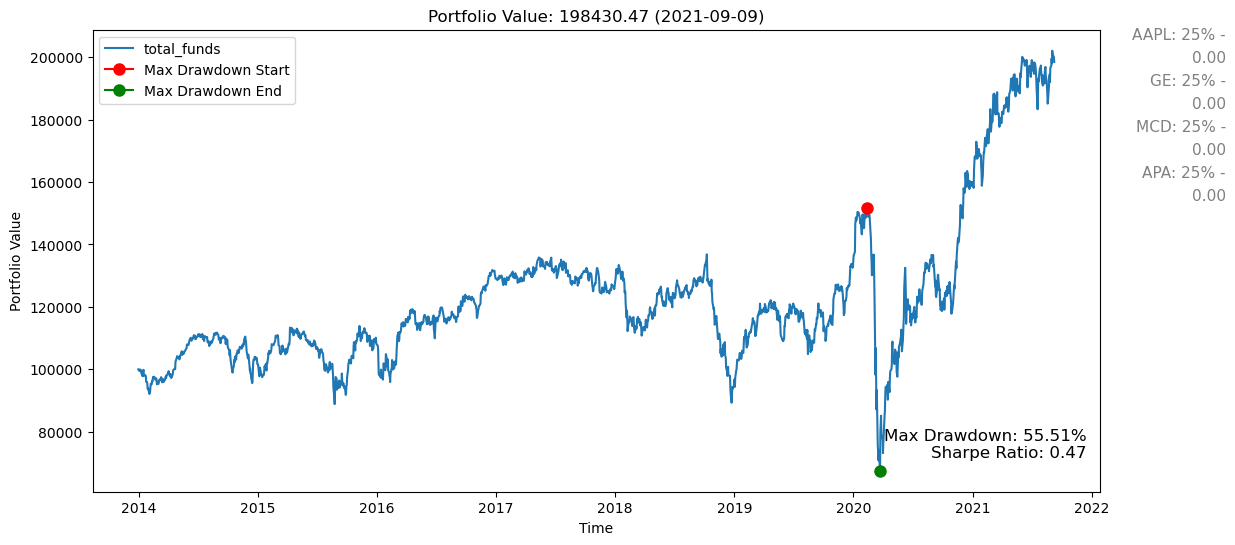

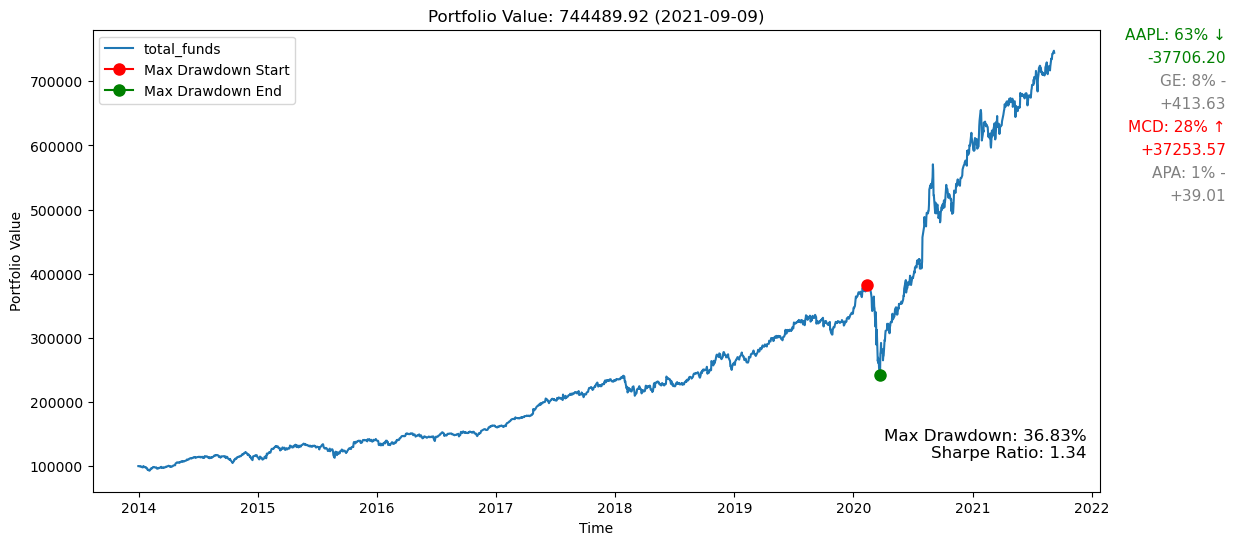

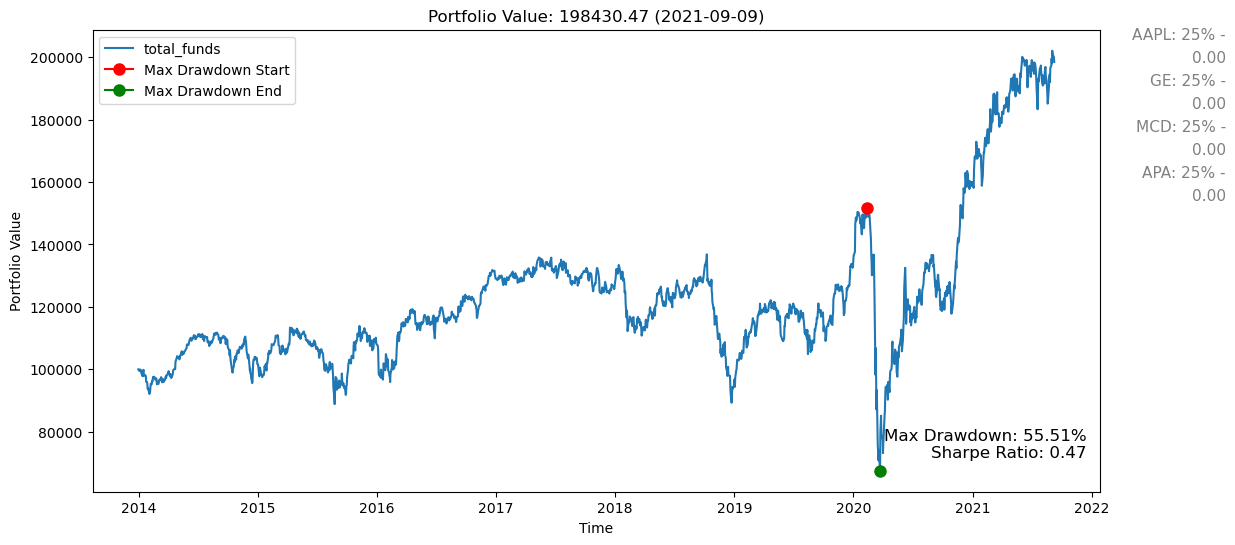

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

<Figure size 1300x600 with 0 Axes>

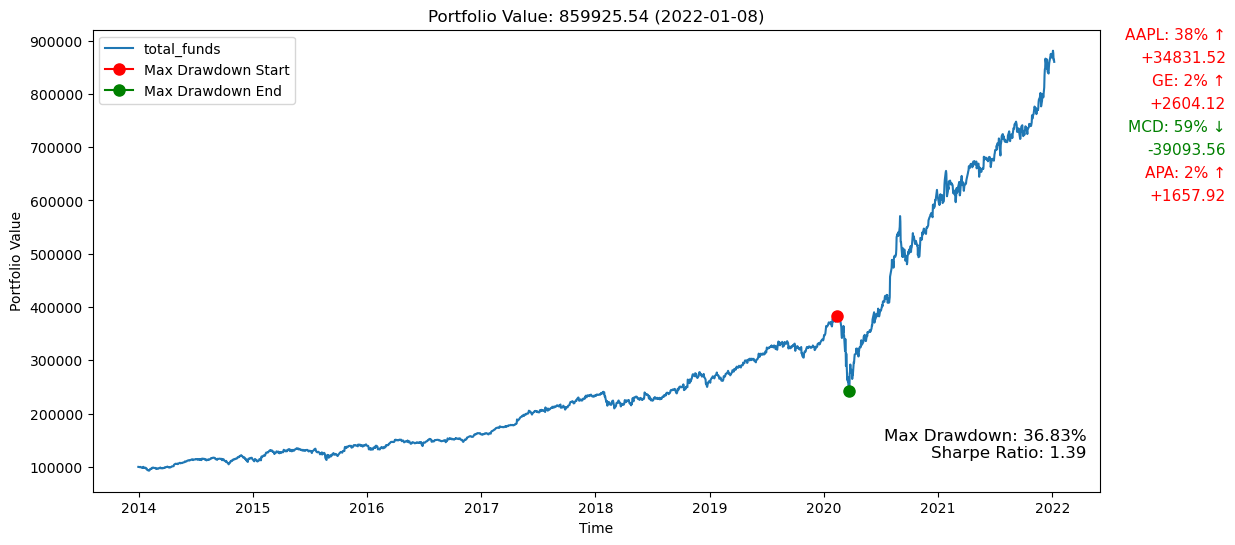

In [3]:
language = "chinese"

def close_app():
    root.destroy()

def toggle_language():
    global language
    if language == "chinese":
        language = "english"
        root.title("Stock Prediction Application")
    else:
        language = "chinese"
        root.title("股票預測應用程式")
    update_language()



label2 = None
MWU_button = None
viewer_button = None
viewer2_button = None
viewer3_button = None
reset_button = None
def update_language():
    global label2, MWU_button, viewer_button, viewer2_button, viewer3_button, reset_button, prediction_completed_message
    if language == "chinese":
        label.config(text="請輸入所有要預測的股票代碼（以逗號分隔，例如：AAPL, GOOG, AMD, AMZN）: ")
        predict_button.config(text="分析股票")
        print_stocks_button.config(text="顯示已訓練的股票")
        change_app_button.config(text="切換到訓練APP")
        exit_button.config(text="退出")
        language_button.config(text="Switch to English version")

        label2.config(text="請輸入MWU分配的資金")
        MWU_button.config(text="開始MWU策略")
        viewer_button.config(text="顯示預測圖表")
        viewer2_button.config(text="顯示疊加圖表")
        viewer3_button.config(text="顯示總結圖表")
        reset_button.config(text="重置")
        prediction_completed_message = "股票預測完成！"
        
    else:
        label.config(text="Please enter all the stock codes you want to predict (separated by commas, e.g., AAPL, GOOG, AMD, AMZN): ")
        predict_button.config(text="Analyze Stocks")
        print_stocks_button.config(text="Show Trained Stocks")
        change_app_button.config(text="Switch to Training APP")
        exit_button.config(text="Exit")
        language_button.config(text="切換到中文版")


        label2.config(text="Please Enter Funds for MWU Allocation")
        MWU_button.config(text="Start MWU Strategy")
        viewer_button.config(text="Show Prediction Chart")
        viewer2_button.config(text="Show Overlay Chart")
        viewer3_button.config(text="Show Summary Chart")
        reset_button.config(text="Reset")
        prediction_completed_message = "Stock prediction completed!"
        

root = tk.Tk()
root.title("股票預測應用程式")

image = Image.open('background.jpg')
background_image = ImageTk.PhotoImage(image)
background_label = tk.Label(root, image=background_image)
background_label.place(relwidth=1, relheight=1)

style = ttkthemes.ThemedStyle(root)
style.set_theme("ubuntu")

root.resizable(False, False)

label = ttk.Label(root, text="請輸入所有要預測的股票代碼（以逗號分隔，例如：AAPL, GOOG, AMD, AMZN）: ", foreground="black", font=('Helvetica', 12))
label.pack(padx=10, pady=10)

stock_entry = ttk.Entry(root, width=30)
stock_entry.pack(padx=10, pady=10)

style.configure('Custom.TButton', foreground='black', font=('Helvetica', 12))

predict_button = ttk.Button(root, text="分析股票", style='Custom.TButton',  command=predict_stocks) 
predict_button.pack(padx=10, pady=10)

print_stocks_button = ttk.Button(root, text="顯示已訓練的股票", style='Custom.TButton', command=lambda: print_finish_stocks("Model/"))
print_stocks_button.pack(padx=10, pady=10)

change_app_button = ttk.Button(root, text="切換到訓練APP", style='Custom.TButton', command=change_app)
change_app_button.pack(padx=10, pady=10)

exit_button = ttk.Button(root, text="退出", style='Custom.TButton', command=close_app)
exit_button.pack(padx=10, pady=10)

language_button = ttk.Button(root, text="Switch to English version" if language == "chinese" else "切換到中文版", style='Custom.TButton', command=toggle_language)
language_button.pack(padx=10, pady=10)

root.mainloop()